In [56]:
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt
import math as mt
import scipy.special
import seaborn as sns
plt.style.use('fivethirtyeight')
from statsmodels.graphics.tsaplots import plot_acf
import pandas as pd

# <font face="gotham" color="orange"> Markov Chain Monte Carlo </font>

The **Markov Chain Monte Carlo** (**MCMC**) is a class of algorithm to simulate a distribution that has no closed-form expression. To illustrate the mechanism of MCMC, we resort to the example of Gamma-Poisson conjugate.

Though it has a closed-form expression of posterior, we can still simulate the posterior for demonstrative purpose.

To use MCMC, commonly the Bayes' Theorem is modified without affecting the final result.
$$
P(\lambda \mid y) \propto P(y \mid \lambda)  P(\lambda)
$$
where $\propto$ means proportional to, the integration in the denominator can be safely omitted since it is a constant.

Here we recap the example of hurricanes in the last chapter. The prior elicitation uses


$$
E(\lambda) = \frac{\alpha}{\beta}\\
\text{Var}(\lambda) = \frac{\alpha}{\beta^2}
$$

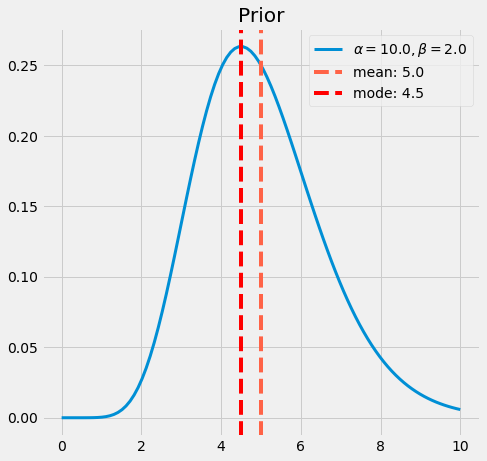

In [2]:
x = np.linspace(0, 10, 100)
params = [10, 2]
gamma_pdf = sp.stats.gamma.pdf(x, a=params[0], scale=1/params[1])

fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(x, gamma_pdf, lw = 3, label = r'$\alpha = %.1f, \beta =  %.1f$' % (params[0], params[1]))
ax.set_title('Prior')
mean = params[0]/params[1]
mode = (params[0]-1)/params[1]
ax.axvline(mean, color = 'tomato', ls='--', label='mean: {}'.format(mean))
ax.axvline(mode, color = 'red', ls='--', label='mode: {}'.format(mode))
ax.legend()
plt.show()

1. Because posterior will also be Gamma distribution, we start from proposing a value drawn from posterior
$$
\lambda = 8
$$
This is an arbitrary value, which is called the **initial value**. 

2. Calculate the likelihood of observing $k=3$ hurricanes given $\lambda=8$.
$$
\mathcal{L}(3 ; 8)=\frac{\lambda^{k} e^{-\lambda}}{k !}=\frac{8^{3} e^{-8}}{3 !}=0.1075
$$

In [3]:
def pois_lh(k, lamda):
    lh = lamda**k*np.exp(-lamda)/mt.factorial(k)
    return lh

In [4]:
lamda_init = 8
k = 3
pois_lh(k = k, lamda = lamda_init)

0.02862614424768101

3. Calculate prior 
$$
g(\lambda ; \alpha, \beta)=\frac{\beta^{\alpha} \lambda^{\alpha-1} e^{-\beta \lambda}}{\Gamma(\alpha)}
$$

In [5]:
def gamma_prior(alpha, beta, lamda):
    prior = (beta**alpha*lamda**(alpha-1)*np.exp(-beta*lamda))/sp.special.gamma(alpha)
    return prior

In [6]:
lamda_current = lamda_init
alpha=10
beta=2
gamma_prior(alpha=alpha, beta=beta, lamda=lamda_current)

0.0426221247856141

4. Calculate the posterior with the first guess $\lambda=8$ and we denote it as $\lambda_{current}$

In [7]:
k=3
posterior_current = pois_lh(k=k, lamda=lamda_current) * gamma_prior(alpha=10, beta=2, lamda=lamda_current)
posterior_current

0.0012201070922556493

5. Draw a second value $\lambda_{proposed}$ from a **proposal distribution** with $\mu=\lambda_{current}$ and $\sigma = .5$. The $\sigma$ here is called **tuning parameter**, which will be clearer in following demonstrations.

In [8]:
tuning_param = .5
lamda_prop = sp.stats.norm(loc=lamda_current, scale=tuning_param).rvs()
lamda_prop

7.783033590805784

6. Calculate posterior based on the $\lambda_{proposed}$.

In [9]:
posterior_prop = gamma_prior(alpha, beta, lamda=lamda_prop)*pois_lh(k, lamda=lamda_prop)
posterior_prop

0.0016818486401991774

7. Now we have two posteriors. To proceed, we need to make some rules to throw one away. Here we introduce the **Metropolis Algorithm**. The probability threshold for accepting $\lambda_{proposed}$ is 
$$
P_{\text {accept }}=\min \left(\frac{P\left(\lambda_{\text {proposed }} \mid \text { data }\right)}{P\left(\lambda_{\text {current }} \mid \text { data }\right)}, 1\right)
$$

In [10]:
print(posterior_current)
print(posterior_prop)

0.0012201070922556493
0.0016818486401991774


In [11]:
prob_threshold = np.min([posterior_prop/posterior_current, 1])
prob_threshold

1.0

It means the probability of accepting $\lambda_{proposed}$ is $1$. What if the smaller value is $\frac{\text{posterior proposed}}{\text{posterior current}}$, let's say $\text{prob_threshold}=.768$. The algorithm requires a draw from a uniform distribution, if the draw is smaller than $.768$, go for $\lambda_{proposed}$ if larger then stay with $\lambda_{current}$.

8. The demonstrative algorithm will be

In [12]:
if sp.stats.uniform.rvs() > .768:
    print('stay with current lambda')
else:
    print('accept next lambda')

accept next lambda


9. If we accept $\lambda_{proposed}$, redenote it as $\lambda_{current}$, then repeat from step $2$ for thousands of times. 

## <font face="gotham" color="orange"> Combine All Steps </font>

We will join all the steps in a loop for thousands of times (the number of repetition depends on your time constraint and your computer's capacity).

In [13]:
def gamma_poisson_mcmc(lamda_init = 2, k = 3, alpha = 10, beta= 2, tuning_param = 1, chain_size = 10000): 
    np.random.seed(123)
    lamda_current = lamda_init

    lamda_mcmc = []
    pass_rate = []
    post_ratio_list = []

    for i in range(chain_size):
        lh_current = pois_lh(k = k, lamda = lamda_current)
        prior_current = gamma_prior(alpha=alpha, beta=beta, lamda=lamda_current)
        posterior_current = lh_current*prior_current

        lamda_proposal = sp.stats.norm(loc=lamda_current, scale=tuning_param).rvs()
        prior_next = gamma_prior(alpha=alpha, beta=beta, lamda=lamda_proposal)
        lh_next = pois_lh(k, lamda=lamda_proposal)

        posterior_proposal = lh_next*prior_next
        post_ratio = posterior_proposal/posterior_current

        prob_next = np.min([post_ratio, 1])
        unif_draw = sp.stats.uniform.rvs()
        post_ratio_list.append(post_ratio)

        if unif_draw < prob_next:
            lamda_current = lamda_proposal
            lamda_mcmc.append(lamda_current)
            pass_rate.append('Y')
        else:
            lamda_mcmc.append(lamda_current)
            pass_rate.append('N')
    return lamda_mcmc, pass_rate

The proposal distribution must be symmetrical otherwise the Markov chain won't reach an equilibrium distribution. Also the tuning parameter should be set at a value which maintains $30\%\sim50\%$ acceptance.

In [14]:
lamda_mcmc, pass_rate = gamma_poisson_mcmc(chain_size = 10000) 

In [15]:
yes = ['Pass','Not Pass']
counts = [pass_rate.count('Y'), pass_rate.count('N')]

x = np.linspace(0, 10, 100)
params_prior = [10, 2]
gamma_pdf_prior = sp.stats.gamma.pdf(x, a=params_prior[0], scale=1/params_prior[1])

We assume $1$ year, the data records in total $3$ hurricanes. Obtain the analytical posterior, therefore we can compare the  simulation and the analytical distribution.
\begin{align}
\alpha_{\text {posterior }}&=\alpha_{0}+\sum_{i=1}^{n} x_{i} = 10+3=13\\
\beta_{\text {posterior }}&=\beta_{0}+n = 2+1=3
\end{align}
Prepare the analytical Gamma distribution

In [16]:
params_post = [13, 3]
gamma_pdf_post = sp.stats.gamma.pdf(x, a=params_post[0], scale=1/params_post[1])

Because initial sampling might not converge to the equilibrium, so the first $1/10$ values of the Markov chain can be safely dropped. This $1/10$ period is termed as **burn-in** period. Also in order to minimize the _autocorrelation_ issue, we can perform **pruning** process to drop every other (or even five) observation(s).

That is why we use ```lamda_mcmc[1000::2]``` in codes below.

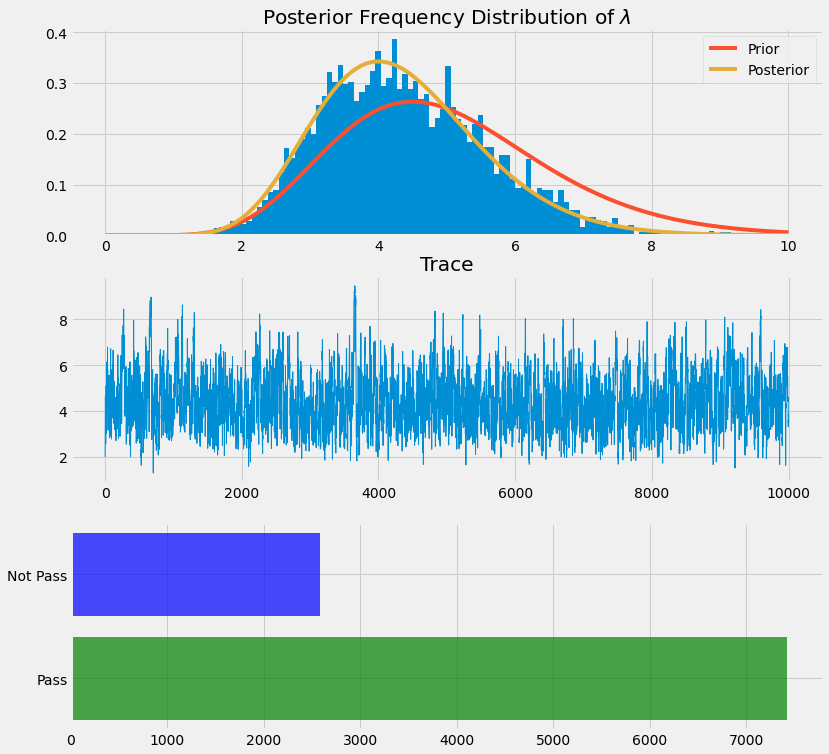

In [17]:
fig, ax = plt.subplots(figsize = (12, 12), nrows = 3, ncols = 1)
ax[0].hist(lamda_mcmc[1000::2], bins=100, density=True)
ax[0].set_title(r'Posterior Frequency Distribution of $\lambda$')
ax[0].plot(x, gamma_pdf_prior, label='Prior')
ax[0].plot(x, gamma_pdf_post, label='Posterior')
ax[0].legend()
ax[1].plot(np.arange(len(lamda_mcmc)), lamda_mcmc, lw=1)
ax[1].set_title('Trace')
ax[2].barh(yes, counts, color=['green', 'blue'], alpha=.7)
plt.show()

# <font face="gotham" color="orange"> Diagnostics of MCMC </font>

The demonstration above has been fine-tuned deliberately to circumvent potential errors, which are common in MCMC algorithm designing. We will demonstrate how it happens, what probable remedies we might possess. 

## <font face="gotham" color="orange"> Invalid Proposal </font>

Following the Gamma-Poisson example, if we have a proposal distribution with $\mu=1$, the random draw from this proposal distribution might be a negative number, however the posterior is a Gamma distribution which only resides in positive domain.

The remedy of this type of invalid proposal is straightforward, multiply $-1$ onto all negative draws. 

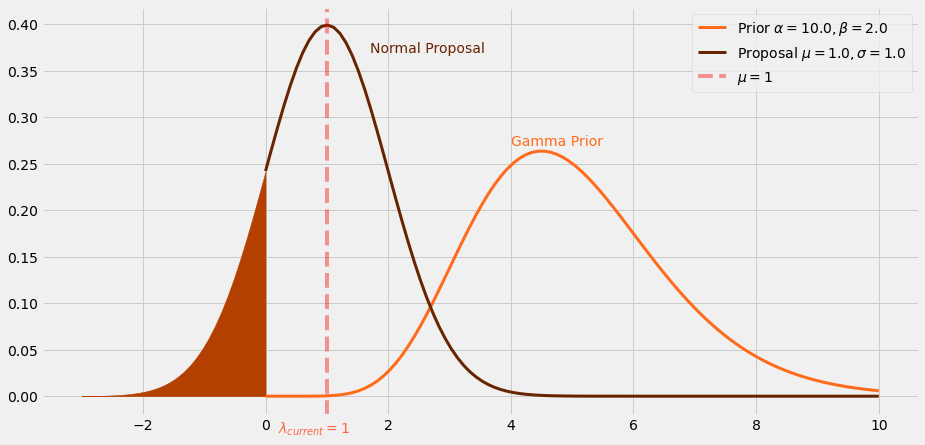

In [66]:
x_gamma = np.linspace(-3, 12, 100)
x_norm = np.linspace(-3, 6, 100)
params_gamma = [10, 2]
gamma_pdf = sp.stats.gamma.pdf(x, a=params_gamma[0], scale=1/params_gamma[1])

mu = 1
sigma = 1
normal_pdf = sp.stats.norm.pdf(x, loc=mu, scale=sigma)

fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(x, gamma_pdf, lw = 3, label = r'Prior $\alpha = %.1f, \beta =  %.1f$' % (params[0], params[1]), color='#FF6B1A')
ax.plot(x, normal_pdf, lw = 3, label = r'Proposal $\mu=%.1f , \sigma= %.1f$' % (mu, sigma), color='#662400')
ax.text(4, .27, 'Gamma Prior', color ='#FF6B1A')
ax.text(1.7, .37, 'Normal Proposal', color ='#662400')
ax.text(.2, -.04, r'$\lambda_{current}=1$', color ='tomato')

x_fill = np.linspace(-3, 0, 30)
y_fill = sp.stats.norm.pdf(x_fill, loc=mu, scale=sigma)
ax.fill_between(x_fill, y_fill, color ='#B33F00')

ax.axvline(mu, color = 'red', ls='--', label=r'$\mu=${}'.format(mu), alpha=.4)
ax.legend()
plt.show()

Two lines of codes will solve this issue
```
        if lamda_proposal < 0:
            lamda_proposal *= -1
```

In [19]:
def gamma_poisson_mcmc_1(lamda_init = 2, k = 3, alpha = 10, beta= 2, tuning_param = 1, chain_size = 10000): 
    np.random.seed(123)
    lamda_current = lamda_init

    lamda_mcmc = []
    pass_rate = []
    post_ratio_list = []

    for i in range(chain_size):
        lh_current = pois_lh(k = k, lamda = lamda_current)
        prior_current = gamma_prior(alpha=alpha, beta=beta, lamda=lamda_current)
        posterior_current = lh_current*prior_current

        lamda_proposal = sp.stats.norm(loc=lamda_current, scale=tuning_param).rvs()
        if lamda_proposal < 0:
            lamda_proposal *= -1
        prior_next = gamma_prior(alpha=alpha, beta=beta, lamda=lamda_proposal)
        lh_next = pois_lh(k, lamda=lamda_proposal)

        posterior_proposal = lh_next*prior_next
        post_ratio = posterior_proposal/posterior_current

        prob_next = np.min([post_ratio, 1])
        unif_draw = sp.stats.uniform.rvs()
        post_ratio_list.append(post_ratio)

        if unif_draw < prob_next:
            lamda_current = lamda_proposal
            lamda_mcmc.append(lamda_current)
            pass_rate.append('Y')
        else:
            lamda_mcmc.append(lamda_current)
            pass_rate.append('N')
    return lamda_mcmc, pass_rate

This time we can set chain size much larger.

In [35]:
lamda_mcmc, pass_rate = gamma_poisson_mcmc_1(chain_size = 100000, tuning_param = 1)

As you can see the frequency distribution is also much smoother.

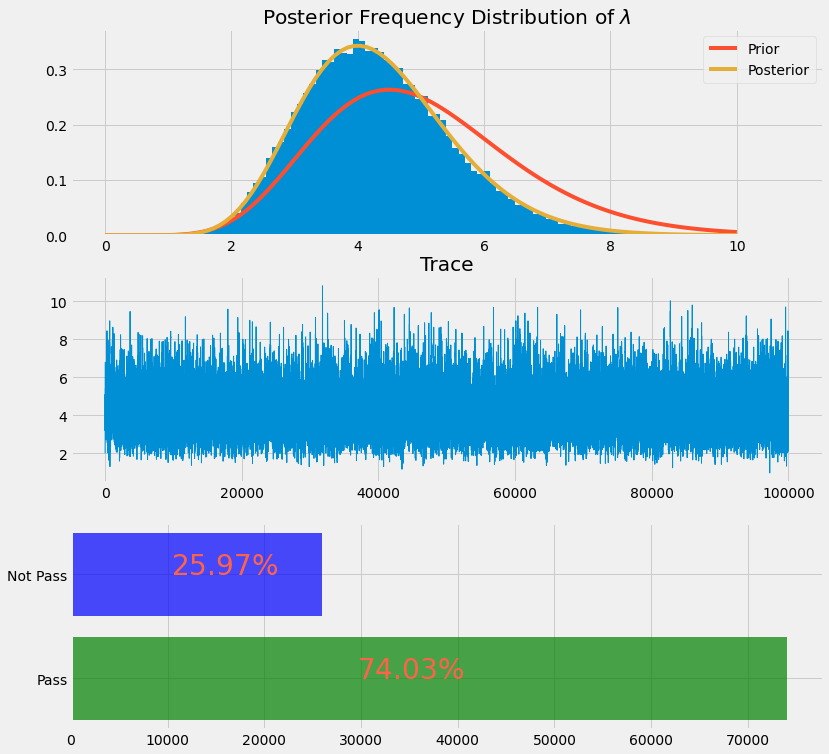

In [36]:
y_rate = pass_rate.count('Y')/len(pass_rate)
n_rate = pass_rate.count('N')/len(pass_rate)
yes = ['Pass','Not Pass']
counts = [pass_rate.count('Y'), pass_rate.count('N')]

fig, ax = plt.subplots(figsize = (12, 12), nrows = 3, ncols = 1)
ax[0].hist(lamda_mcmc[int(len(lamda_mcmc)/10)::2], bins=100, density=True)
ax[0].set_title(r'Posterior Frequency Distribution of $\lambda$')
ax[0].plot(x, gamma_pdf_prior, label='Prior')
ax[0].plot(x, gamma_pdf_post, label='Posterior')
ax[0].legend()
ax[1].plot(np.arange(len(lamda_mcmc)), lamda_mcmc, lw=1)
ax[1].set_title('Trace')

ax[2].barh(yes, counts, color=['green', 'blue'], alpha=.7)
ax[2].text(counts[1]*.4, 'Not Pass', r'${}\%$'.format(np.round(n_rate*100,2)), color ='tomato', size = 28)
ax[2].text(counts[0]*.4, 'Pass', r'${}\%$'.format(np.round(y_rate*100,2)), color ='tomato', size = 28)
plt.show()

## <font face="gotham" color="orange"> Numerical Overflow </font>

If prior and likelihood are extremely close to $0$, the product would be even closer to $0$. This would cause storage error in computer due to the binary system. 

The remedy is to use the log version of Bayes' Theorem, i.e.

$$
\ln{P(\lambda \mid y)} \propto \ln{P(y \mid \lambda)}+  \ln{P(\lambda)}
$$

Also the acceptance rule can be converted into log version

$$
\ln{ \left(\frac{P\left(\lambda_{proposed } \mid  y \right)}{P\left(\lambda_{current} \mid y \right)}\right)}
=\ln{P\left(\lambda_{proposed } \mid  y \right)} - \ln{P\left(\lambda_{current } \mid  y \right)} 
$$

In [39]:
def gamma_poisson_mcmc_2(lamda_init = 2, k = 3, alpha = 10, beta= 2, tuning_param = 1, chain_size = 10000): 
    np.random.seed(123)
    lamda_current = lamda_init

    lamda_mcmc = []
    pass_rate = []
    post_ratio_list = []

    for i in range(chain_size):
        log_lh_current = np.log(pois_lh(k = k, lamda = lamda_current))
        log_prior_current = np.log(gamma_prior(alpha=alpha, beta=beta, lamda=lamda_current))
        log_posterior_current = log_lh_current + log_prior_current

        lamda_proposal = sp.stats.norm(loc=lamda_current, scale=tuning_param).rvs()
        if lamda_proposal < 0:
            lamda_proposal *= -1
        log_prior_next = np.log(gamma_prior(alpha=alpha, beta=beta, lamda=lamda_proposal))
        log_lh_next = np.log(pois_lh(k, lamda=lamda_proposal))

        log_posterior_proposal = log_lh_next + log_prior_next
        log_post_ratio = log_posterior_proposal - log_posterior_current
        post_ratio = np.exp(log_post_ratio)

        prob_next = np.min([post_ratio, 1])
        unif_draw = sp.stats.uniform.rvs()
        post_ratio_list.append(post_ratio)

        if unif_draw < prob_next:
            lamda_current = lamda_proposal
            lamda_mcmc.append(lamda_current)
            pass_rate.append('Y')
        else:
            lamda_mcmc.append(lamda_current)
            pass_rate.append('N')
    return lamda_mcmc, pass_rate

With the use of log posterior and acceptance rule, the numerical overflow is unlikely to happen anymore, which means we can set a much longer Markov chain and also a larger tuning parameter.

In [48]:
lamda_mcmc, pass_rate = gamma_poisson_mcmc_2(chain_size = 100000, tuning_param = 3)

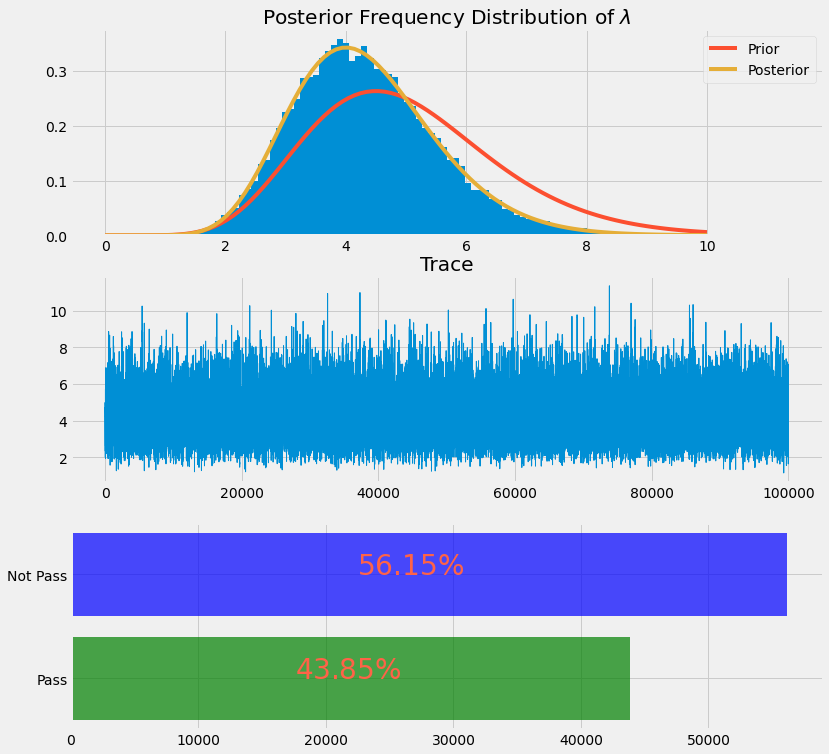

In [49]:
y_rate = pass_rate.count('Y')/len(pass_rate)
n_rate = pass_rate.count('N')/len(pass_rate)
yes = ['Pass','Not Pass']
counts = [pass_rate.count('Y'), pass_rate.count('N')]

fig, ax = plt.subplots(figsize = (12, 12), nrows = 3, ncols = 1)
ax[0].hist(lamda_mcmc[int(len(lamda_mcmc)/10)::2], bins=100, density=True)
ax[0].set_title(r'Posterior Frequency Distribution of $\lambda$')
ax[0].plot(x, gamma_pdf_prior, label='Prior')
ax[0].plot(x, gamma_pdf_post, label='Posterior')
ax[0].legend()
ax[1].plot(np.arange(len(lamda_mcmc)), lamda_mcmc, lw=1)
ax[1].set_title('Trace')

ax[2].barh(yes, counts, color=['green', 'blue'], alpha=.7)
ax[2].text(counts[1]*.4, 'Not Pass', r'${}\%$'.format(np.round(n_rate*100,2)), color ='tomato', size = 28)
ax[2].text(counts[0]*.4, 'Pass', r'${}\%$'.format(np.round(y_rate*100,2)), color ='tomato', size = 28)
plt.show()

Larger tuning parameter yields a lower pass ($30\%\sim50\%$) rate that is exactly what we are seeking for.

## <font face="gotham" color="orange"> Pruning </font>

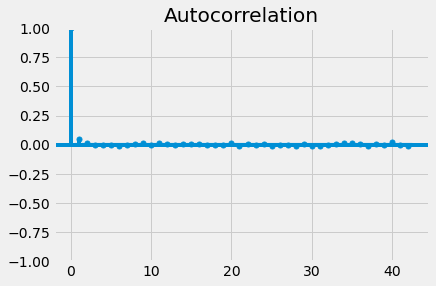

In [63]:
lamda_mcmc = np.array(lamda_mcmc)

g = plot_acf(lamda_mcmc[::7])

In [22]:
data = np.random.randn(20)

In [23]:
def sampler(data, samples=1000, mu_init=.5, proposal_width=.5, plot=False, mu_prior_mu=0, mu_prior_sd=1.):
    mu_current = mu_init
    posterior = [mu_current]
    for i in range(samples):
        # suggest new position
        mu_proposal = sp.stats.norm(mu_current, proposal_width).rvs()

        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = sp.stats.norm(mu_current, 1).pdf(data).prod()
        likelihood_proposal = sp.stats.norm(mu_proposal, 1).pdf(data).prod()
        
        # Compute prior probability of current and proposed mu        
        prior_current = sp.stats.norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = sp.stats.norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
        
        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal
        
        # Accept proposal?
        p_accept = p_proposal / p_current
        
        # Usually would include prior probability, which we neglect here for simplicity
        accept = np.random.rand() < p_accept
        
        if accept:
            # Update position
            mu_current = mu_proposal
        
        posterior.append(mu_current)
        
    return np.array(posterior)


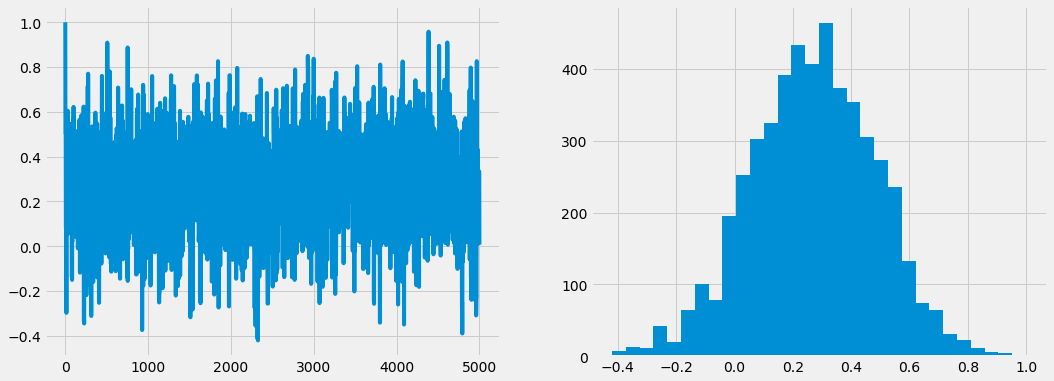

In [24]:
posterior = sampler(data, samples=5000, mu_init=1.)
fig, ax = plt.subplots(figsize=(16, 6), nrows=1, ncols=2)
ax[0].plot(posterior)
ax[0].set_xlabel='sample'
ax[0].set_xlabel='mu'
ax[1].hist(posterior, bins=30)
plt.show()